# Self-supervised DAS denoising (demo) 

In [1]:
import h5py
import torch
import numpy as np
import torch.nn as nn
from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow
from das_denoise_training import train_augmentation
from sklearn.model_selection import train_test_split

### small amount of data

In [96]:
datah5 = '/fd1/QibinShi_data/akdas/decimator2_2023-06-18_09.15.03_UTC.h5'
with h5py.File(datah5, 'r') as f:
    time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 100:7600]
    delta_space = f['Acquisition'].attrs['SpatialSamplingInterval']
    sample_rate = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    
time_data=(time_data-np.mean(time_data))/np.std(time_data)

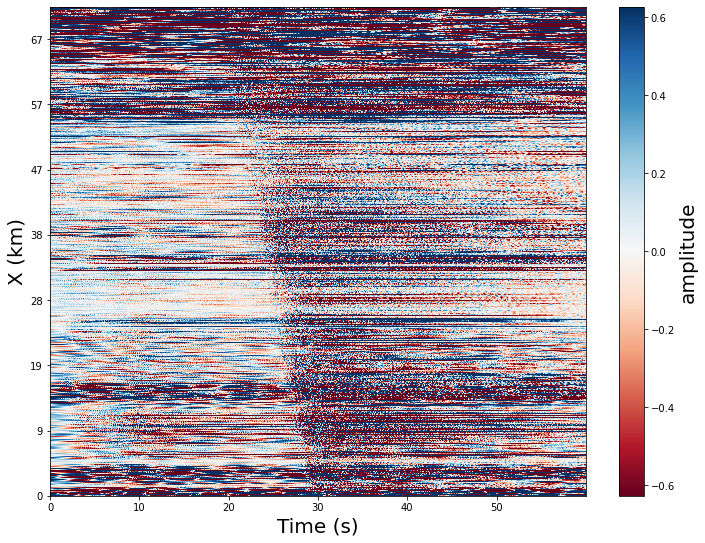

In [97]:
# %% visualize data
plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[0]), np.arange(time_data.shape[1])
plt.pcolormesh(x, y, time_data.T, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 7500, 1000), (np.arange(0, delta_space*7500, 1000*delta_space)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

In [98]:
x = time_data.T[np.newaxis, :, :]
x = np.repeat(x, 5, axis=0)  # duplicate data 4 times
training_data = dataflow(x[:, 0:4500])
validation_data = dataflow(x[:, 4500:])

In [1]:
print(x.dtype)

NameError: name 'x' is not defined

### Construct the neural network

In [99]:
""" Initialize the U-net model """
model = unet(1, 16, 1024, factors=(5, 3, 2, 2))
devc = try_gpu(i=0)
model = nn.DataParallel(model, device_ids=[0,1,2,3])  # comment if gpus<4 
model.to(devc)

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Training

In [100]:
# %% Hyper-parameters for training
batch_size = 10
lr = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=False)
validate_iter = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [101]:
model, \
avg_train_losses, \
avg_valid_losses = train_augmentation(train_iter,
                                   validate_iter,
                                   model,
                                   loss_fn,
                                   optimizer,
                                   epochs=50,
                                   patience=6,
                                   device=devc,
                                   minimum_epochs=5)

[ 1/50] train_loss: 3819.55174 valid_loss: 0.52756 time per epoch: 4.159 s
[ 2/50] train_loss: 0.59276 valid_loss: 0.21882 time per epoch: 4.117 s
[ 3/50] train_loss: 0.17220 valid_loss: 0.14764 time per epoch: 4.096 s
[ 4/50] train_loss: 0.09958 valid_loss: 0.14043 time per epoch: 4.092 s
[ 5/50] train_loss: 0.08392 valid_loss: 0.14172 time per epoch: 4.114 s
[ 6/50] train_loss: 0.07658 valid_loss: 0.13468 time per epoch: 4.118 s
Validation loss decreased (inf --> 0.134685).  Saving model ...
[ 7/50] train_loss: 0.07439 valid_loss: 0.13335 time per epoch: 4.142 s
Validation loss decreased (0.134685 --> 0.133350).  Saving model ...
[ 8/50] train_loss: 0.07358 valid_loss: 0.13278 time per epoch: 4.127 s
Validation loss decreased (0.133350 --> 0.132779).  Saving model ...
[ 9/50] train_loss: 0.07300 valid_loss: 0.13220 time per epoch: 4.113 s
Validation loss decreased (0.132779 --> 0.132201).  Saving model ...
[10/50] train_loss: 0.07260 valid_loss: 0.13188 time per epoch: 4.104 s
Valida

Text(0.5, 1.0, 'loss curves')

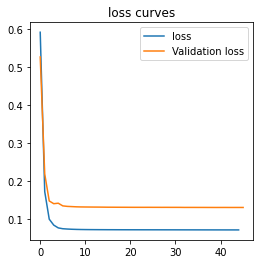

In [102]:
# %% Show loss evolution when training is done
loss = avg_train_losses
val_loss = avg_valid_losses
plt.figure(figsize=(4, 4))
plt.plot(loss[1:], '-', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.legend()
plt.title('loss curves')
# plt.savefig(model_dir + f'/{model_name}_Training_history.png')

### Testing 

In [114]:
# %% numpy arrays
(X, mask), y = validation_data[0:1]
new_mask = np.ones_like(X, dtype=np.float32)

rng = np.random.default_rng(11)
trace_masked = rng.choice(1500, size=1000, replace=False)
new_mask[0, 0, trace_masked, :] = new_mask[0, 0, trace_masked, :] * 0

# %% convert to torch tensors
X = torch.from_numpy(X).to(devc)
mask = torch.from_numpy(mask).to(devc)
new_mask = torch.from_numpy(new_mask).to(try_gpu(i=0))

inputdata=X*new_mask
maskdata=X*(1-new_mask)

In [115]:
# %% make a prediction use the best model
model.eval() 
with torch.no_grad():
    pred = model(inputdata)
    
# %% convert back to numpy for plotting
inputdata = inputdata[0,0].to('cpu').numpy()
maskdata = maskdata[0,0].to('cpu').numpy()
rawdata = X[0,0].to('cpu').numpy()
pred = pred[0,0].to('cpu').numpy()

[Text(0, 0, '0'),
 Text(0, 200, '1'),
 Text(0, 400, '3'),
 Text(0, 600, '5'),
 Text(0, 800, '7'),
 Text(0, 1000, '9'),
 Text(0, 1200, '11'),
 Text(0, 1400, '13')]

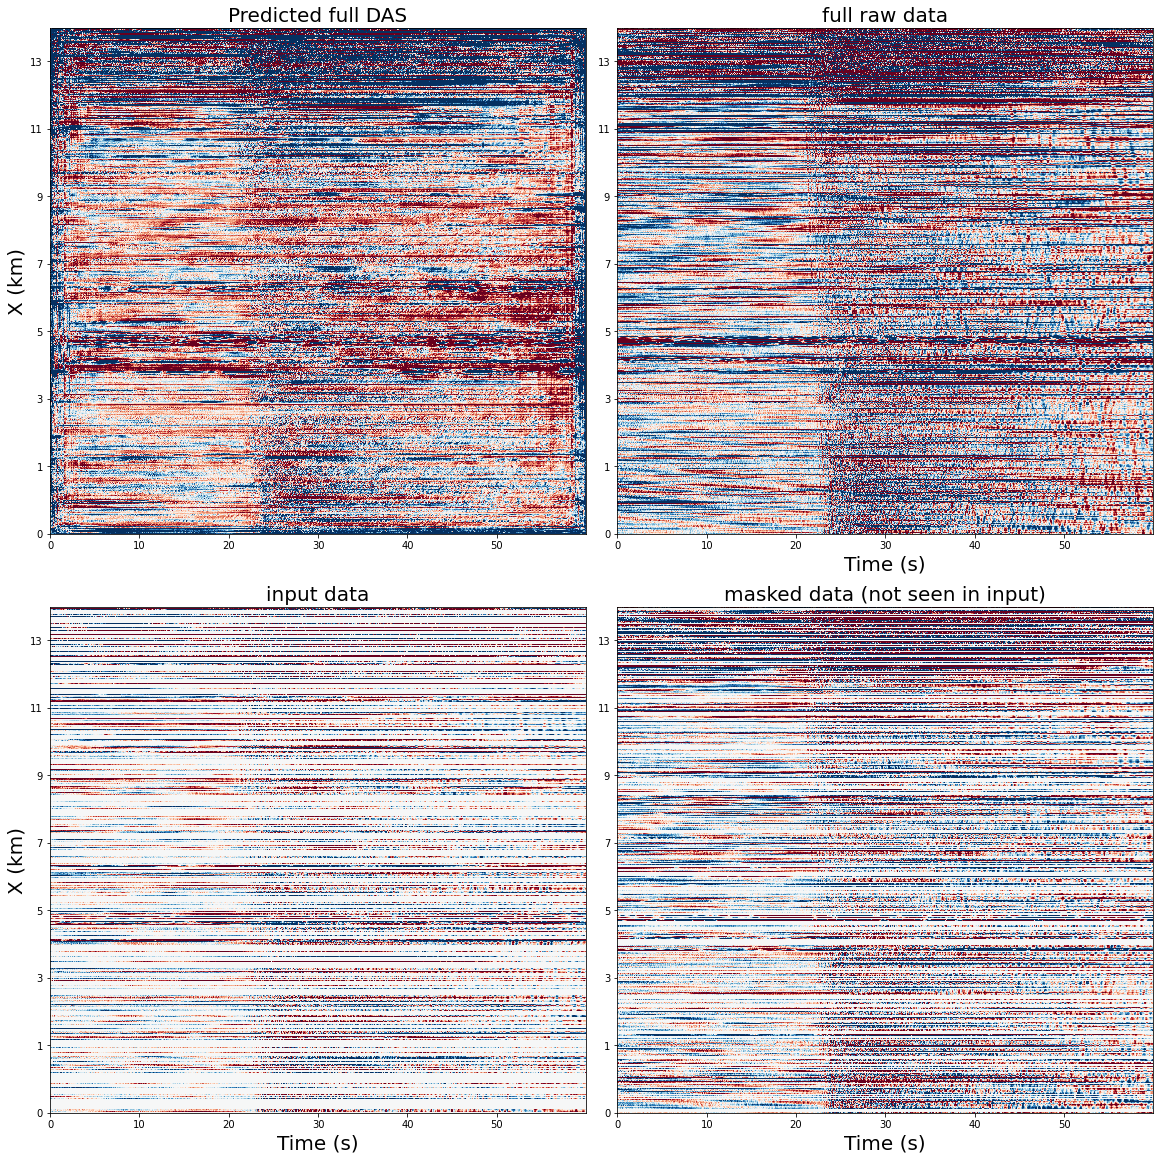

In [116]:
# visualize all
fig, ax = plt.subplots(2, 2, figsize=(16, 16), constrained_layout=True)

x, y = np.arange(pred.shape[1]), np.arange(pred.shape[0])

max_amp = np.median(np.fabs(pred))*2
ax[0,0].pcolormesh(x, y, pred, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

ax[0,0].set_title("Predicted full DAS", fontsize=20)
ax[0,0].set_xticks(np.arange(0, 1500, 250)) 
ax[0,0].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[0,0].set_ylabel("X (km)", fontsize=20)
ax[0,0].set_yticks(np.arange(0, 1500, 200))
ax[0,0].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

max_amp = np.median(np.fabs(rawdata))*2
ax[0,1].pcolormesh(x, y, rawdata, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

ax[0,1].set_xlabel("Time (s)", fontsize=20)
ax[0,1].set_xticks(np.arange(0, 1500, 250)) 
ax[0,1].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[0,1].set_title("full raw data", fontsize=20)
ax[0,1].set_yticks(np.arange(0, 1500, 200))
ax[0,1].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

# max_amp = np.median(np.fabs(inputdata))*2
ax[1,0].pcolormesh(x, y, inputdata, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

ax[1,0].set_title("input data", fontsize=20)
ax[1,0].set_xlabel("Time (s)", fontsize=20)
ax[1,0].set_xticks(np.arange(0, 1500, 250)) 
ax[1,0].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[1,0].set_ylabel("X (km)", fontsize=20)
ax[1,0].set_yticks(np.arange(0, 1500, 200))
ax[1,0].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

# max_amp = np.median(np.fabs(maskdata))*2
ax[1,1].pcolormesh(x, y, maskdata, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

ax[1,1].set_xlabel("Time (s)", fontsize=20)
ax[1,1].set_xticks(np.arange(0, 1500, 250)) 
ax[1,1].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[1,1].set_title("masked data (not seen in input)", fontsize=20)
ax[1,1].set_yticks(np.arange(0, 1500, 200))
ax[1,1].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))